In [1]:
#Importiamo librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

os.makedirs("figures", exist_ok=True)


In [2]:
# Caricamento News
# (stesso file per Netflix e SVB)
news_distil = pd.read_csv("google_news_distilbert_multi.csv")
news_xlm    = pd.read_csv("google_news_xlm_sentiment.csv")


In [3]:
# Se esiste una colonna identificativa (es. "Ticker"), la usiamo
if "Ticker" in news_distil.columns:
    nflx_distil = news_distil[news_distil["Ticker"] == "Netflix"].copy()
    nflx_xlm    = news_xlm[news_xlm["Ticker"] == "Netflix"].copy()

    svb_distil  = news_distil[news_distil["Ticker"] == "SVB"].copy()
    svb_xlm     = news_xlm[news_xlm["Ticker"] == "SVB"].copy()
else:
    # Altrimenti: stesso news dataset per entrambi
    nflx_distil = news_distil.copy()
    nflx_xlm    = news_xlm.copy()

    svb_distil  = news_distil.copy()
    svb_xlm     = news_xlm.copy()


In [4]:
# Processing NEWS
def process_news(df_distil, df_xlm):
    """
    Processing news/chat:
    - merge DistilBERT + XLM sullo stesso articolo (link)
    - aggregazione giornaliera
    """

    # Merge sul link (news-level)
    df = pd.merge(
        df_distil,
        df_xlm[["link", "xlm_score"]],
        on="link",
        how="inner"
    )

    # Data giornaliera
    df["date"] = pd.to_datetime(df["date"]).dt.floor("D")

    # Model Disagreement Index (news-level)
    df["mdi_news"] = (
        df["xlm_score"] - df["distilbert_multi_score"]
    ).abs()

    # Aggregazione giornaliera
    daily = df.groupby("date").agg(
        news_volume=("link", "count"),
        sentiment_distilbert=("distilbert_multi_score", "mean"),
        sentiment_xlm=("xlm_score", "mean"),
        MDI_social=("mdi_news", "mean")
    ).reset_index()

    return daily


In [5]:
# Costruzione indicatori (Netflix / SVB)
# Netflix
nflx_news_daily = process_news(nflx_distil, nflx_xlm)

# SVB
svb_news_daily  = process_news(svb_distil, svb_xlm)


In [6]:
# Controllo rapido NEWS daily (sanity check)
print("Netflix news daily:")
print(nflx_news_daily.head())
print("\nSVB news daily:")
print(svb_news_daily.head())


Netflix news daily:
        date  news_volume  sentiment_distilbert  sentiment_xlm  MDI_social
0 2022-04-19           34             -0.794118      -0.381979    0.553151
1 2022-04-20           47             -0.840426      -0.488894    0.536892
2 2022-04-21           19             -0.605263      -0.450260    0.610745
3 2022-04-22           10             -0.800000      -0.447323    0.552677
4 2022-04-23            4             -1.000000      -0.261148    0.738852

SVB news daily:
        date  news_volume  sentiment_distilbert  sentiment_xlm  MDI_social
0 2022-04-19           34             -0.794118      -0.381979    0.553151
1 2022-04-20           47             -0.840426      -0.488894    0.536892
2 2022-04-21           19             -0.605263      -0.450260    0.610745
3 2022-04-22           10             -0.800000      -0.447323    0.552677
4 2022-04-23            4             -1.000000      -0.261148    0.738852


In [7]:
# Caricamento dati di mercato
# Market data
nflx_mkt = pd.read_csv("Netflix_Event_Table.csv", sep=";")
svb_mkt  = pd.read_csv("SVB_KRE_Event_Table.csv", sep=";")

# Date
nflx_mkt["Date"] = pd.to_datetime(nflx_mkt["Date"])
svb_mkt["Date"]  = pd.to_datetime(svb_mkt["Date"])

# Uniformiamo il nome
nflx_mkt = nflx_mkt.rename(columns={"Date": "date"})
svb_mkt  = svb_mkt.rename(columns={"Date": "date"})


In [8]:
# Netflix
nflx_social_market = pd.merge(
    nflx_mkt,
    nflx_news_daily,
    on="date",
    how="inner"
)

# SVB
svb_social_market = pd.merge(
    svb_mkt,
    svb_news_daily,
    on="date",
    how="inner"
)

print("Netflix social+market:", nflx_social_market.shape)
print("SVB social+market:", svb_social_market.shape)


Netflix social+market: (15, 10)
SVB social+market: (8, 10)


In [9]:
gdelt_nflx = pd.read_csv("GDELT_NETFLIX_Analysis.csv", sep=";")
gdelt_svb  = pd.read_csv("GDELT_SVB_Analysis.csv", sep=";")

gdelt_nflx = gdelt_nflx.rename(columns={"day": "date"})
gdelt_svb  = gdelt_svb.rename(columns={"day": "date"})

gdelt_nflx["date"] = pd.to_datetime(gdelt_nflx["date"]).dt.floor("D")
gdelt_svb["date"]  = pd.to_datetime(gdelt_svb["date"]).dt.floor("D")


In [10]:
# Merge finale
# Netflix
nflx_full = pd.merge(
    nflx_social_market,
    gdelt_nflx,
    on="date",
    how="left"
)

# SVB
svb_full = pd.merge(
    svb_social_market,
    gdelt_svb,
    on="date",
    how="left"
)

print("Netflix FULL:", nflx_full.shape)
print("SVB FULL:", svb_full.shape)


Netflix FULL: (15, 12)
SVB FULL: (8, 12)


In [11]:
# Preparazione time series
GDELT_COL = "gdelt_volume"

def prepare_ts(df):
    sub = df[["date", "MDI_social", GDELT_COL, "vol_5d"]].dropna().copy()

    sub["MDI_z"] = (
        (sub["MDI_social"] - sub["MDI_social"].mean()) /
        sub["MDI_social"].std()
    )

    sub["GDELT_z"] = (
        (sub[GDELT_COL] - sub[GDELT_COL].mean()) /
        sub[GDELT_COL].std()
    )

    return sub

svb_ts  = prepare_ts(svb_full)
nflx_ts = prepare_ts(nflx_full)


In [12]:
# Rinomina colonne: social -> news

rename_map = {
    "social_volume": "news_volume",
    "sentiment_distilbert_social": "sentiment_distilbert_news",
    "sentiment_xlm_social": "sentiment_xlm_news",
    "MDI_social": "MDI_news"
}

svb_full = svb_full.rename(columns=rename_map)
nflx_full = nflx_full.rename(columns=rename_map)


In [13]:
# Salvataggio tabelle finali NEWS

svb_full.to_csv(
    "SVB_FINAL_news.csv",
    index=False
)

nflx_full.to_csv(
    "Netflix_FINAL_news.csv",
    index=False
)

print("CSV finali NEWS salvati correttamente:")
print("- SVB_FINAL_news.csv")
print("- Netflix_FINAL_news.csv")

CSV finali NEWS salvati correttamente:
- SVB_FINAL_news.csv
- Netflix_FINAL_news.csv


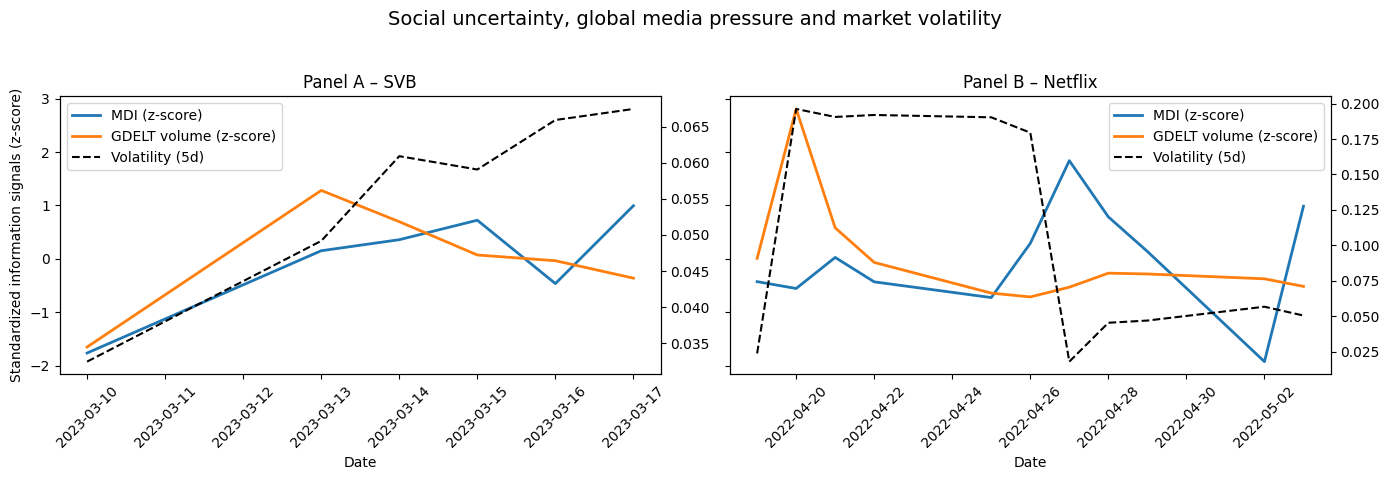

Figura salvata correttamente.


In [ ]:
# FIGURA FINALE (CREAZIONE + SALVATAGGIO)


fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# PANEL A — SVB
ax2 = ax1.twinx()

ax1.plot(svb_ts["date"], svb_ts["MDI_z"], label="MDI (z-score)", linewidth=2)
ax1.plot(svb_ts["date"], svb_ts["GDELT_z"], label="GDELT volume (z-score)", linewidth=2)

ax2.plot(
    svb_ts["date"], svb_ts["vol_5d"],
    linestyle="--", color="black",
    label="Volatility (5d)"
)

ax1.set_title("Panel A – SVB")
ax1.set_xlabel("Date")
ax1.set_ylabel("Standardized information signals (z-score)")
ax1.tick_params(axis="x", rotation=45)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# PANEL B — NETFLIX
ax4 = ax3.twinx()

ax3.plot(nflx_ts["date"], nflx_ts["MDI_z"], label="MDI (z-score)", linewidth=2)
ax3.plot(nflx_ts["date"], nflx_ts["GDELT_z"], label="GDELT volume (z-score)", linewidth=2)

ax4.plot(
    nflx_ts["date"], nflx_ts["vol_5d"],
    linestyle="--", color="black",
    label="Volatility (5d)"
)

ax3.set_title("Panel B – Netflix")
ax3.set_xlabel("Date")
ax3.tick_params(axis="x", rotation=45)

# Forza tick ogni 2 giorni (20, 22, 24, 26, ...)
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Legenda combinata PANEL B
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc="upper right")

# TITOLO + LAYOUT
fig.suptitle(
    "Social uncertainty, global media pressure and market volatility",
    fontsize=14
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# SALVATAGGIO QUI (PRIMA DI SHOW)
fig.savefig(
    "figures/Figure1_news_MDI_GDELT_volatility.png",
    dpi=300,
    bbox_inches="tight"
)

# ORA mostra
plt.show()

print("Figura salvata correttamente.")


In [18]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Carica i dati (These lines are now redundant as we will use svb_ts and nflx_ts from previous cells)
# svb = pd.read_csv("SVB_FINAL_news.csv", parse_dates=["date"])
# nflx = pd.read_csv("Netflix_FINAL_news.csv", parse_dates=["date"])

# Crea figura a due pannelli
fig = make_subplots(
    rows=1, cols=2,
    shared_yaxes=True,
    subplot_titles=("Panel A – SVB", "Panel B – Netflix"),
    specs=[[{"secondary_y": True}, {"secondary_y": True}]]
)

# --- PANEL A: SVB ---
fig.add_trace(
    go.Scatter(
        x=svb_ts["date"], y=svb_ts["MDI_z"],
        name="MDI (z-score)",
        line=dict(color="rgba(31,119,180,1)", width=2),
        fill="tozeroy",
        fillcolor="rgba(31,119,180,0.25)"
    ),
    row=1, col=1, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=svb_ts["date"], y=svb_ts["GDELT_z"],
        name="GDELT volume (z-score)",
        line=dict(color="rgba(174,199,232,1)", width=2),
        fill="tozeroy",
        fillcolor="rgba(174,199,232,0.25)"
    ),
    row=1, col=1, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=svb_ts["date"], y=svb_ts["vol_5d"],
        name="Volatility (5d)",
        line=dict(color="black", dash="dash")
    ),
    row=1, col=1, secondary_y=True
)

# --- PANEL B: NETFLIX ---
fig.add_trace(
    go.Scatter(
        x=nflx_ts["date"], y=nflx_ts["MDI_z"],
        name="MDI (z-score)",
        line=dict(color="rgba(255,105,180,1)", width=2),
        fill="tozeroy",
        fillcolor="rgba(255,105,180,0.25)"
    ),
    row=1, col=2, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=nflx_ts["date"], y=nflx_ts["GDELT_z"],
        name="GDELT volume (z-score)",
        line=dict(color="rgba(255,182,193,1)", width=2),
        fill="tozeroy",
        fillcolor="rgba(255,182,193,0.25)"
    ),
    row=1, col=2, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=nflx_ts["date"], y=nflx_ts["vol_5d"],
        name="Volatility (5d)",
        line=dict(color="black", dash="dash")
    ),
    row=1, col=2, secondary_y=True
)

# Layout finale
fig.update_layout(
    title="News-based uncertainty, global media pressure and market volatility",
    template="simple_white",
    hovermode="x unified",
    legend=dict(orientation="h", y=-0.2),
    height=450
)

fig.show()